#Zasoby

* Multivariate time-series forecasting from Seattle air quality data

* https://cloud.google.com/bigquery/docs/e2e-journey
* https://cloud.google.com/bigquery/docs/arima-plus-xreg-single-time-series-forecasting-tutorial

* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-multivariate-time-series

#Cele

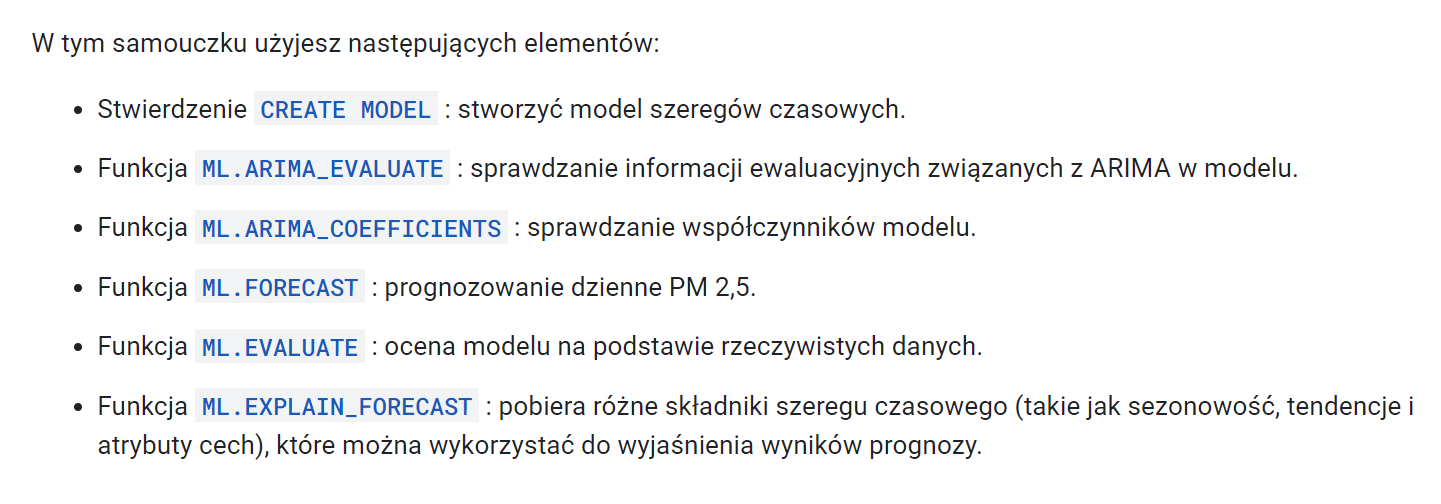

#Utwórz szeregi czasowe z dodatkowymi funkcjami (Krok 1)

* W celu dalszych analiz łączę dane z trzech tabel

In [ ]:
%%bigquery


CREATE TABLE `pmackowka_us.table_0151` AS

WITH
  pm25_daily AS (
    SELECT
      avg(arithmetic_mean) AS pm25, date_local AS date
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_nonfrm_daily_summary`
    WHERE
      city_name = 'Seattle'
      AND parameter_name = 'Acceptable PM2.5 AQI & Speciation Mass'
    GROUP BY date_local
  ),

  wind_speed_daily AS (
    SELECT
      avg(arithmetic_mean) AS wind_speed, date_local AS date
    FROM
      `bigquery-public-data.epa_historical_air_quality.wind_daily_summary`
    WHERE
      city_name = 'Seattle'
      AND parameter_name = 'Wind Speed - Resultant'
    GROUP BY date_local

  ),
  temperature_daily AS (
    SELECT
      avg(first_max_value) AS temperature, date_local AS date
    FROM
      `bigquery-public-data.epa_historical_air_quality.temperature_daily_summary`
    WHERE
      city_name = 'Seattle'
      AND parameter_name = 'Outdoor Temperature'
    GROUP BY date_local
  )

SELECT
  pm25_daily.date AS date, pm25, wind_speed, temperature
FROM pm25_daily
JOIN wind_speed_daily USING (date)
JOIN temperature_daily USING (date)

In [ ]:
%%bigquery

SELECT
  *
FROM
  `prj-ecom-p-ad-server-1077.pmackowka_us.table_0151`
ORDER BY
  date desc

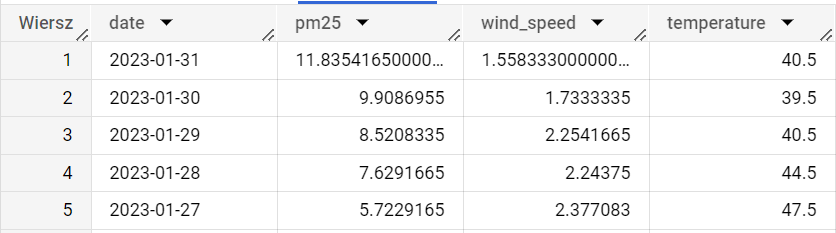

#Wizualizuj szeregi czasowe, które chcesz prognozować (Opcjonalny Krok 2)

* Przed utworzeniem modelu warto zobaczyć, jak wygląda wejściowy szereg czasowy. Możesz to zrobić za pomocą Looker Studio.

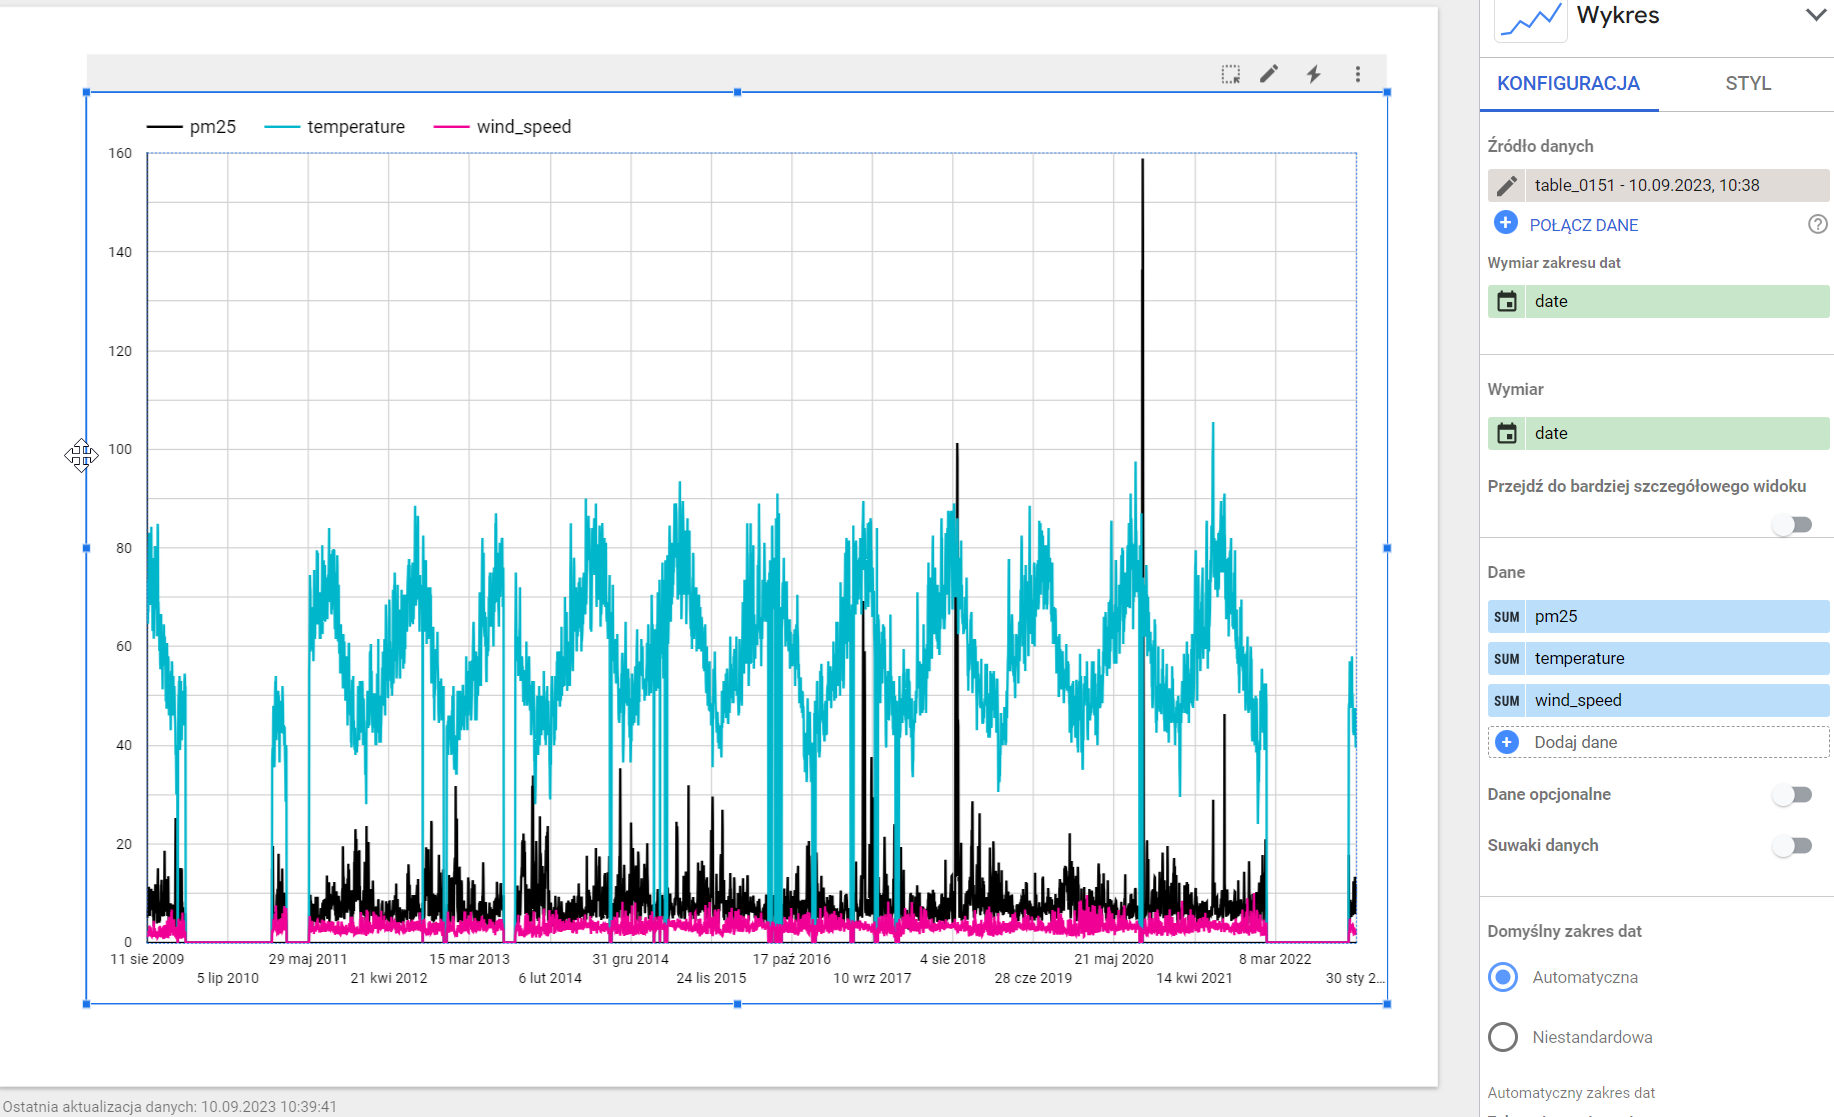

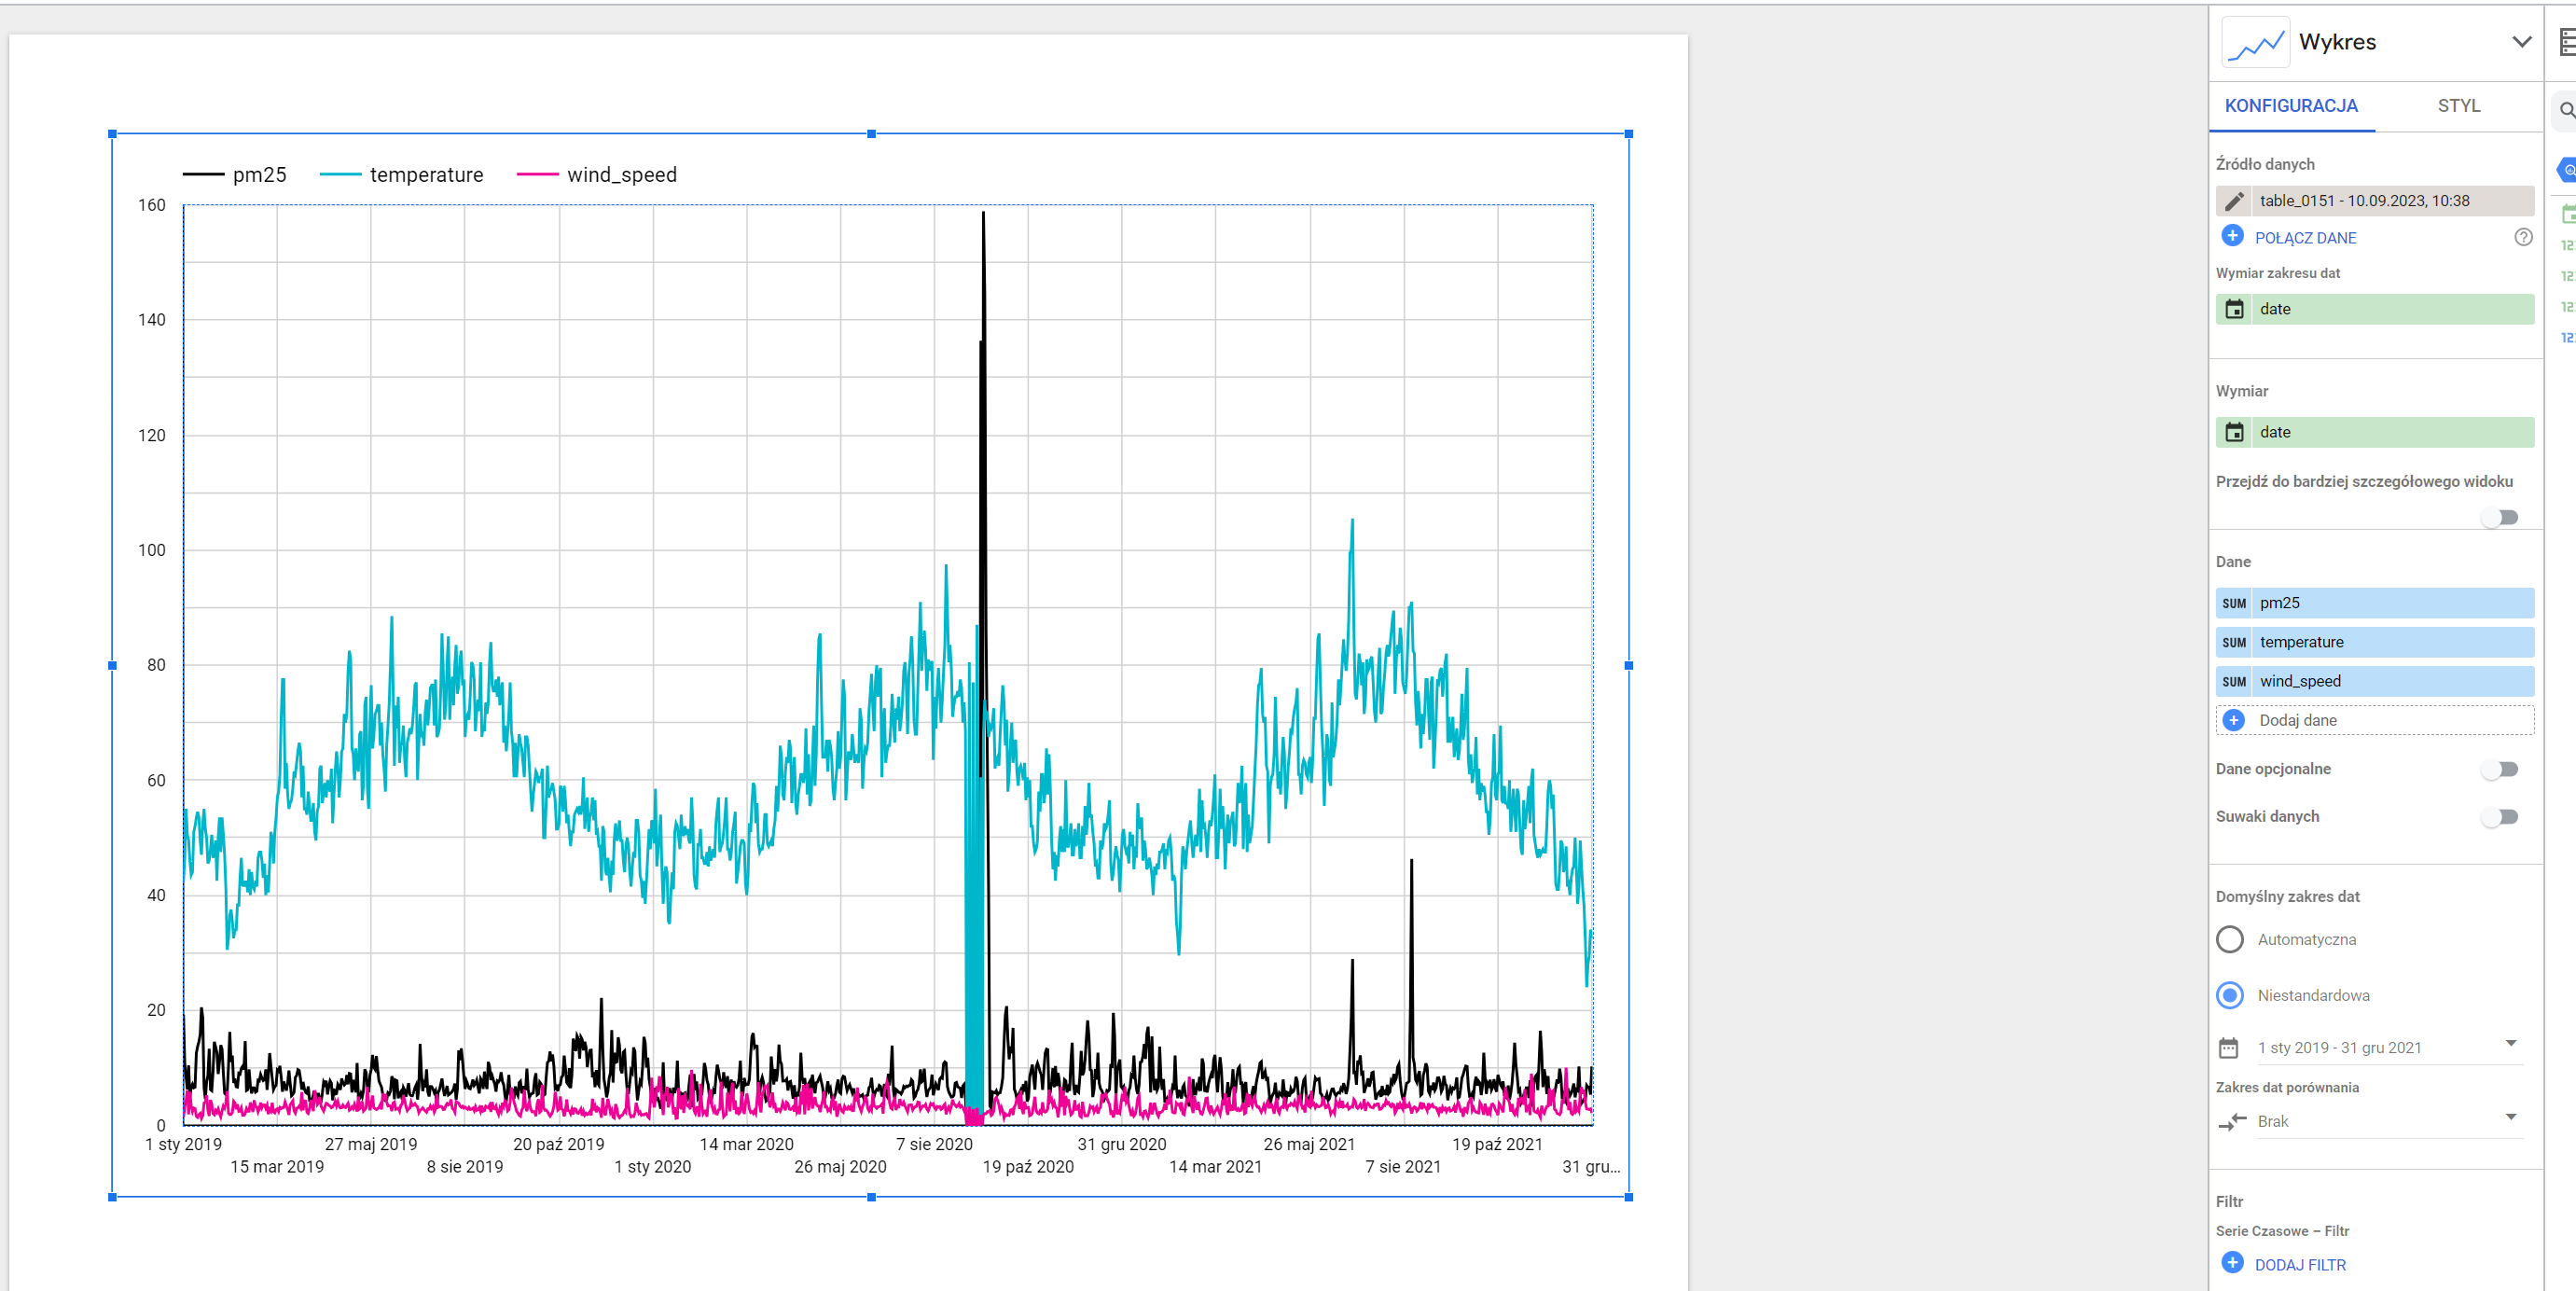

#Utwórz model szeregów czasowych (Krok 3)

##CREATE OR REPLACE MODEL

* Klauzula `OPTIONS(model_type='ARIMA_PLUS_XREG', time_series_timestamp_col='date', ...)` wskazuje, że tworzysz model ARIMA z zewnętrznymi regresorami. Domyślnie, `auto_arima=TRUE` więc auto.ARIMA algorytm automatycznie dostraja hiperparametry w ARIMA_PLUS_XREG modelach.

* Algorytm dopasowuje dziesiątki potencjalnych modeli i wybiera najlepszy z najniższym kryterium informacyjnym `Akaike (AIC)`.

* Ponadto, ponieważ wartością domyślną jest `data_frequency='AUTO_FREQUENCY'`, proces uczenia automatycznie określa częstotliwość danych wejściowych szeregów czasowych.



In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `pmackowka_us.model_0151`
  OPTIONS (
    MODEL_TYPE = 'ARIMA_PLUS_XREG',
    time_series_timestamp_col = 'date',
    time_series_data_col = 'pm25')

AS
SELECT
  date,
  pm25, # etykieta
  temperature, # funkcja
  wind_speed # funkcja
FROM
  `pmackowka_us.table_0151`
WHERE
  date BETWEEN DATE('2012-01-01') AND DATE('2020-12-31')

#Sprawdź metryki oceny wszystkich ocenianych modeli (Krok 4)

## ML.ARIMA_EVALUATE

* Po utworzeniu modelu możesz użyć `ML.ARIMA_EVALUATE` funkcji, aby wyświetlić metryki oceny wszystkich modeli kandydujących ocenianych podczas procesu automatycznego dostrajania hiperparametrów.

* Domyślnie to zapytanie zwraca metryki oceny wszystkich modeli kandydatów.

* Model w pierwszym rzędzie ma najniższy AIC i jest uważany za najlepszy model. Ten najlepszy model jest zapisywany jako model ostateczny i używany podczas wywoływania poleceń `ML.FORECAST, ML.EVALUATE i ML.ARIMA_COEFFICIENTS`, jak pokazano w poniższych krokach.

In [ ]:
%%bigquery

SELECT
 *
FROM
 ML.ARIMA_EVALUATE(MODEL pmackowka_us.model_0151)

order by AIC

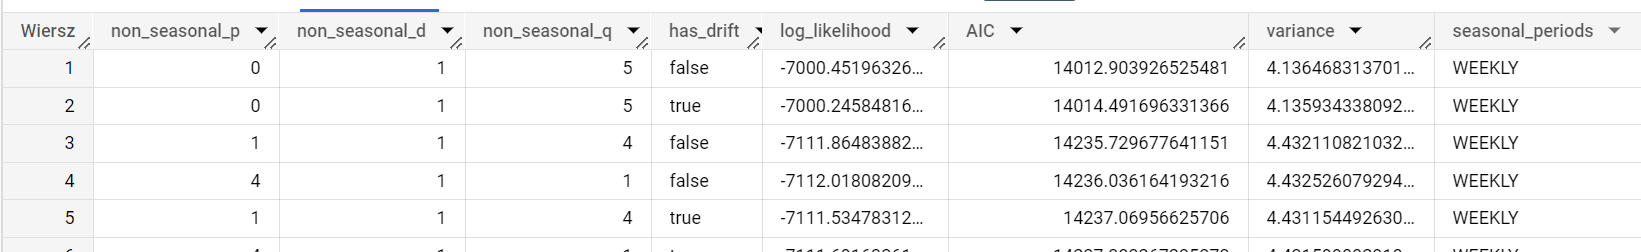

#Sprawdź współczynniki swojego modelu (Krok 5)

##ML.ARIMA_COEFFICIENTS

In [ ]:
%%bigquery

SELECT
 *
FROM
 ML.ARIMA_COEFFICIENTS(MODEL pmackowka_us.model_0151)

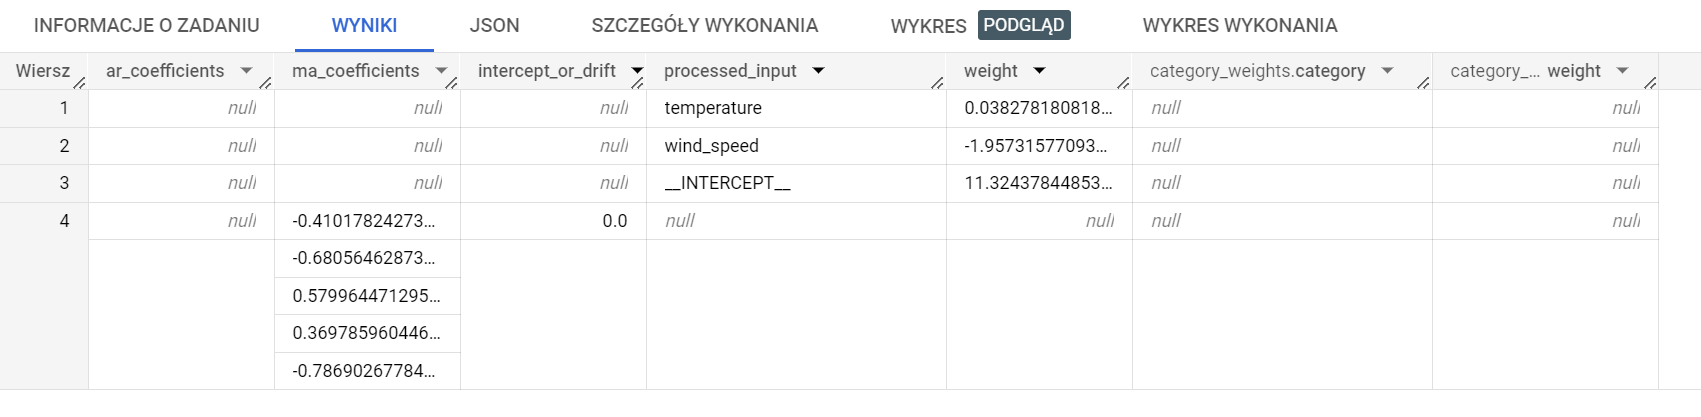

#Użyj modelu do prognozowania szeregów czasowych (Krok 6)

##ML.FORECAST

In [ ]:
%%bigquery

SELECT
*
FROM
ML.FORECAST(MODEL pmackowka_us.model_0151,
STRUCT(30 AS horizon, 0.8 AS confidence_level),

(
  SELECT
    date,
    temperature,
    wind_speed
  FROM
    `pmackowka_us.table_0151`
  WHERE
    date > DATE('2020-12-31')
))

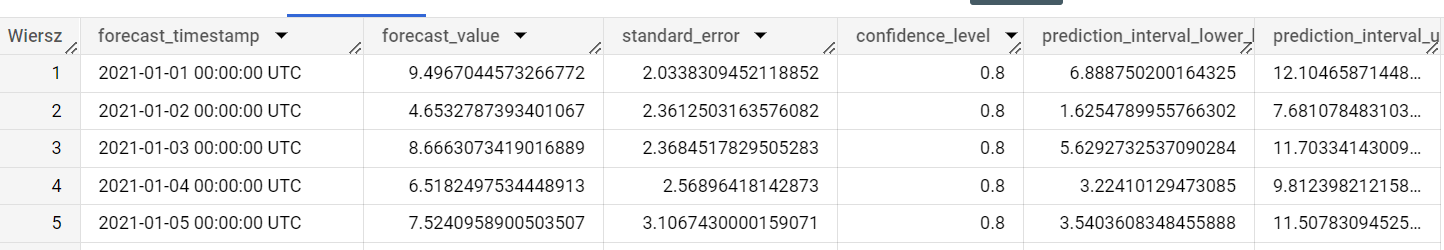

#Oceń dokładność prognozowania na podstawie rzeczywistych danych (Krok 7)

##ML.EVALUATE

* Drugi parametr to dane rzeczywiste wraz z przyszłymi cechami, które służą do prognozowania przyszłych wartości w celu porównania z danymi rzeczywistymi. Trzeci parametr jest strukturą parametrów tej funkcji.

In [ ]:
%%bigquery

SELECT
*
FROM
ML.EVALUATE(MODEL `pmackowka_us.model_0151`,

(
  SELECT
    date,
    pm25,
    temperature,
    wind_speed
  FROM
    `pmackowka_us.table_0151`
  WHERE
    date > DATE('2020-12-31')
),

STRUCT(
  TRUE AS perform_aggregation,
  30 AS horizon))

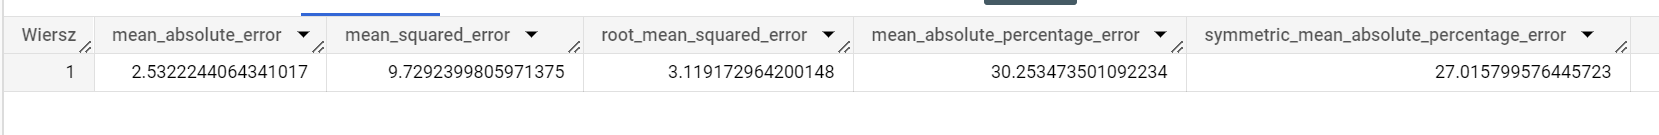

#Wyjaśnij wyniki prognozowania (Krok 8)

##ML.EXPLAIN_FORECAST

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.EXPLAIN_FORECAST(MODEL pmackowka_us.model_0151,
    STRUCT(30 AS horizon, 0.8 AS confidence_level),

    (
      SELECT
        date,
        temperature,
        wind_speed
      FROM
        `pmackowka_us.table_0151`
      WHERE
        date > DATE('2020-12-31')
    ))


  order by time_series_timestamp desc

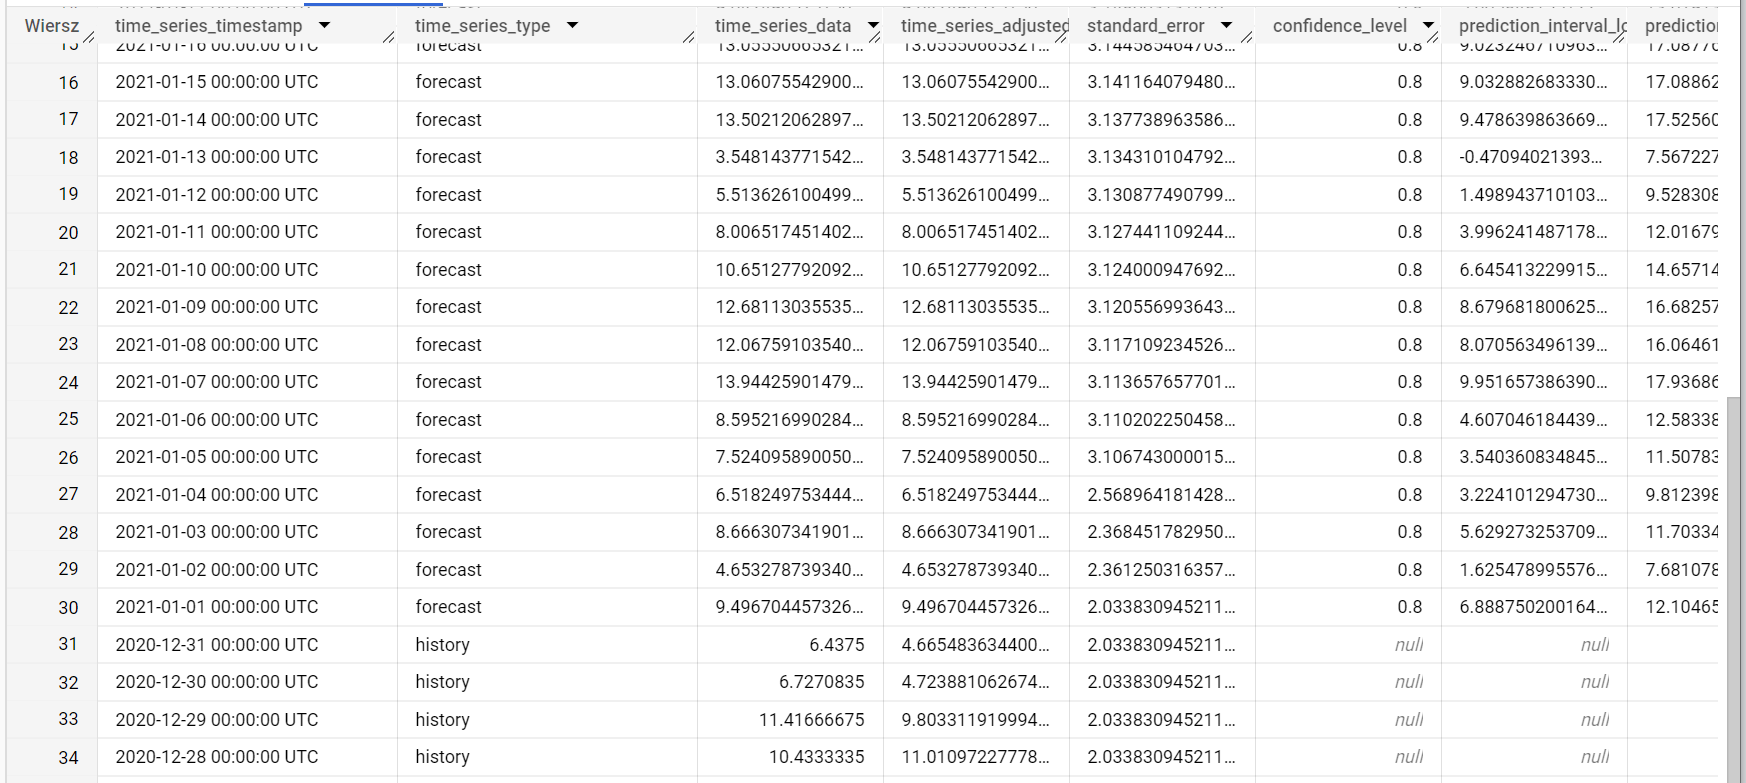